# Aggregate No. of G@C Collection Points & G@C Operating Cost

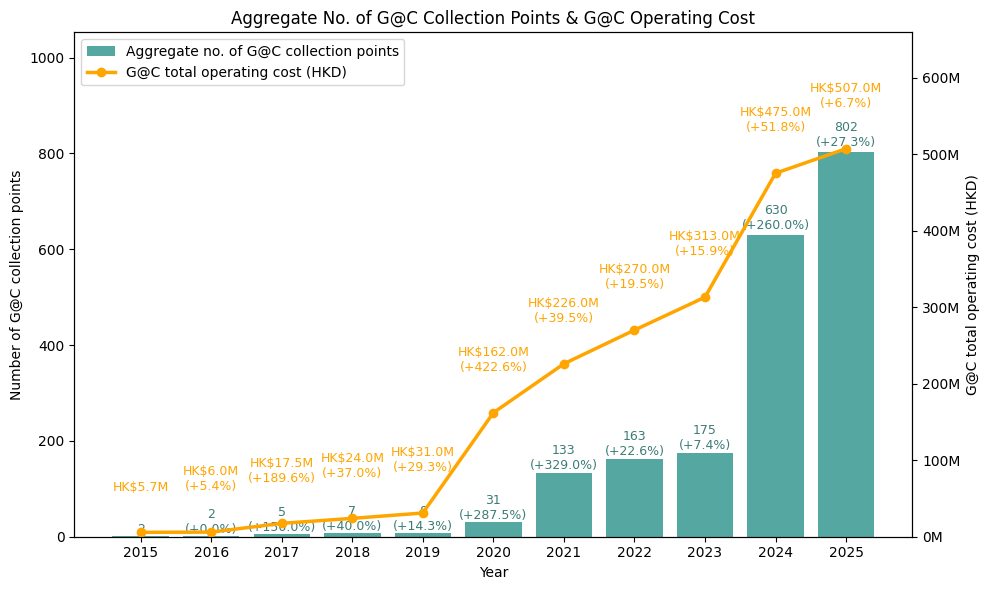

In [2]:
# ==== Install required packages (run these in a terminal, not inside Python) ====
# pip install pandas matplotlib openpyxl

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from pathlib import Path
import math
import numpy as np

# -------------------------------------------------------
# 1. Load data from the Excel file
# -------------------------------------------------------
excel_path = "../General Stats_G@C_clean.xlsx"

# Sheet with years & collection points
hk = pd.read_excel(
    excel_path,
    sheet_name="HK MSW Volume and Recycling Rat"
)

# Sheet with G@C total operating cost
gc = pd.read_excel(
    excel_path,
    sheet_name="G@C Recyclables Collection Volu"
)

# -------------------------------------------------------
# 2. Prepare the relevant data
#    - points: years with collection points (2015–2025)
#    - cost:   fiscal years mapped to calendar year (2015–2025)
# -------------------------------------------------------
col_year       = "Year"
col_points     = "Number of G@C collection points"
col_cost       = "G@C total operating cost"

# --- points data (bars) ---
points_df = hk[[col_year, col_points]].copy()
points_df = points_df[points_df[col_year].notna() & points_df[col_points].notna()].copy()

points_df["Year_int"] = points_df[col_year].astype(int)
points_df["points"]   = pd.to_numeric(points_df[col_points], errors="coerce")
points_df = points_df.sort_values("Year_int")

years_points = points_df["Year_int"].tolist()
points       = points_df["points"].tolist()

# year-on-year % change for points
points_pct_change = points_df["points"].pct_change() * 100
points_pct_map = dict(zip(points_df["Year_int"], points_pct_change))

# --- operating cost data (line) ---
# Fiscal year text like "2015-16" -> take first 4 digits as calendar year
gc_df = gc[[col_year, col_cost]].copy()
gc_df = gc_df[gc_df[col_year].notna() & gc_df[col_cost].notna()].copy()

gc_df["Year_int"] = gc_df[col_year].astype(str).str[:4].astype(int)

gc_df["cost_hkd"] = (
    gc_df[col_cost]
    .astype(str)
    .str.replace(",", "", regex=False)
    .astype(float)
)
gc_df = gc_df.sort_values("Year_int")

cost_map = dict(zip(gc_df["Year_int"], gc_df["cost_hkd"]))

cost_pct_change = gc_df["cost_hkd"].pct_change() * 100
cost_pct_map = dict(zip(gc_df["Year_int"], cost_pct_change))

# Align cost series with all point years (2015–2025)
cost_aligned     = [cost_map.get(y, float("nan")) for y in years_points]
cost_pct_aligned = [cost_pct_map.get(y, float("nan")) for y in years_points]

# -------------------------------------------------------
# 3. Plot: teal bars (points) + brown line (operating cost)
# -------------------------------------------------------
fig, ax1 = plt.subplots(figsize=(10, 6))

x = range(len(years_points))

# --- Left axis: aggregate no. of collection points (bars) ---
bars = ax1.bar(
    x,
    points,
    color="#55a8a2",   # teal
    label="Aggregate no. of G@C collection points",
)

ax1.set_xlabel("Year")
ax1.set_ylabel("Number of G@C collection points")

ax1.set_xticks(list(x))
ax1.set_xticklabels([str(y) for y in years_points], rotation=0)

# Bar labels: value\n(% change)
for xi, bar, val, year in zip(x, bars, points, years_points):
    pct = points_pct_map.get(year, float("nan"))
    value_text = f"{val:.0f}"
    if math.isnan(pct):
        label = value_text
    else:
        label = f"{value_text}\n({pct:+.1f}%)"
    ax1.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() * 1.01,
        label,
        ha="center",
        va="bottom",
        fontsize=9,
        color="#3b7c77",
    )

# Extra headroom so bar labels aren’t cut off
y1_min, y1_max = ax1.get_ylim()
ax1.set_ylim(y1_min, y1_max * 1.25)

# --- Right axis: G@C operating cost (line) ---
ax2 = ax1.twinx()

def millions_formatter(val, pos):
    return f"{int(val / 1_000_000):,}M"

ax2.yaxis.set_major_formatter(FuncFormatter(millions_formatter))

line_cost, = ax2.plot(
    x,
    cost_aligned,          # NaN for any year without cost
    color="#FFA500",       # soft brown
    marker="o",
    linewidth=2.5,
    label="G@C total operating cost (HKD)",
)

ax2.set_ylabel("G@C total operating cost (HKD)")

# Use max of non-NaN costs for axis + offsets
if any(not math.isnan(v) for v in cost_aligned):
    cost_max = np.nanmax(cost_aligned)
else:
    cost_max = 1.0

if cost_max <= 0 or math.isnan(cost_max):
    cost_max = 1.0

ax2.set_ylim(0, cost_max * 1.30)

# Line labels: HK$XXX.XM\n(% change), skip NaN years
cost_offset = cost_max * 0.10
for xi, c, year in zip(x, cost_aligned, years_points):
    if math.isnan(c):
        continue
    pct = cost_pct_map.get(year, float("nan"))
    value_m = c / 1_000_000.0
    value_text = f"HK${value_m:.1f}M"
    if math.isnan(pct):
        label = value_text
    else:
        label = f"{value_text}\n({pct:+.1f}%)"
    ax2.text(
        xi,
        c + cost_offset,
        label,
        ha="center",
        va="bottom",
        fontsize=9,
        color="#FFA500",
    )

# -------------------------------------------------------
# 4. Legend, title, layout
# -------------------------------------------------------
handles = [bars, line_cost]
labels  = [h.get_label() for h in handles]
ax1.legend(handles, labels, loc="upper left")

plt.title("Aggregate No. of G@C Collection Points & G@C Operating Cost")
plt.tight_layout()
plt.show()
